In [23]:
import math
import pickle
import string
import json

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Feature engineering

In [2]:
# Define a function to calculate the frequency of a character or n-gram in a domain
def calculate_frequency(domain, character):
    return domain.count(character)

def calculate_entropy(domain):
    domain_length = len(domain)
    char_count = {char: domain.count(char) for char in set(domain)}
    entropy = -sum((count/domain_length) * (math.log(count/domain_length, 2)) for count in char_count.values())
    return entropy

def count_digits(domain):
    """
    Returns the number of digits in a given domain.
    """
    return sum(char.isdigit() for char in domain)

def count_consonants(domain):
    """
    Returns the number of consonants in a given domain.
    """
    consonants = set(string.ascii_lowercase) - set('aeiou')
    return sum(char.isalpha() and char.lower() in consonants for char in domain)

def count_vowels(domain):
    """
    Returns the number of vowels in a given domain.
    """
    vowels = set('aeiou')
    return sum(char.isalpha() and char.lower() in vowels for char in domain)

def feature_extraction(df: pd.DataFrame) -> pd.DataFrame:
    # Feature Extraction: Domain Length after removing TLD
    df['domain_length'] = df['domain'].apply(lambda x: len(x.split('.')[0]))

    # # Feature Extraction: Subdomain Count
    # df['subdomain_count'] = df['domain'].apply(lambda x: x.count('.') + 1)

    # # Feature Extraction: Top-level Domain (TLD)
    # df['tld'] = df['domain'].apply(lambda x: x.split('.')[-1])

    # Feature Extraction: Lexical Features
    df['num_digits'] = df['domain'].apply(count_digits)

    df['num_consonants'] = df['domain'].apply(count_consonants)

    df['num_vowels'] = df['domain'].apply(count_vowels)
    
    # Feature Extraction: Entropy
    df['entropy'] = df['domain'].apply(lambda x: calculate_entropy(x.split('.')[0]))

    return df

In [3]:
# Load the domain dataset from CSV file
df_legit = pd.read_csv("dga_dataset/dga_legit_domains.csv", header=None, names=['domain'])
df_dga = pd.read_csv("dga_dataset/dga_malicious_domains.csv", header=None, names=['domain'])

#### Analysing the dga generated dataset

In [4]:
df = feature_extraction(df_dga)
df.describe()

,domain_length,num_digits,num_consonants,num_vowels,entropy
count,997.000000,997.000000,997.000000,997.000000,997.000000
mean,15.284855,0.381143,12.614845,5.367101,3.291199
std,6.451635,1.253575,4.486269,2.995251,0.418148
min,6.000000,0.000000,3.000000,0.000000,1.378783
25%,10.000000,0.000000,9.000000,3.000000,3.027169
50%,14.000000,0.000000,12.000000,5.000000,3.308271
75%,21.000000,0.000000,16.000000,9.000000,3.640224
max,26.000000,11.000000,25.000000,13.000000,4.262692


#### Analysing the legit dataset

In [5]:
df = feature_extraction(df_legit)
df.describe()

,domain_length,num_digits,num_consonants,num_vowels,entropy
count,500.00000,500.00000,500.000000,500.000000,500.000000
mean,6.79400,0.09600,6.188000,3.588000,2.303051
std,2.93885,0.48503,2.105593,1.467844,0.580621
min,1.00000,0.00000,1.000000,0.000000,-0.000000
25%,5.00000,0.00000,5.000000,3.000000,1.918296
50%,6.00000,0.00000,6.000000,4.000000,2.321928
75%,8.00000,0.00000,7.000000,4.000000,2.725481
max,20.00000,4.00000,15.000000,9.000000,3.616875


Entropy and domain lenght in the legit dataset is lower than the entropy in the malicious dataset. Try doing it with the top level domain removed. 

## Plotting the data

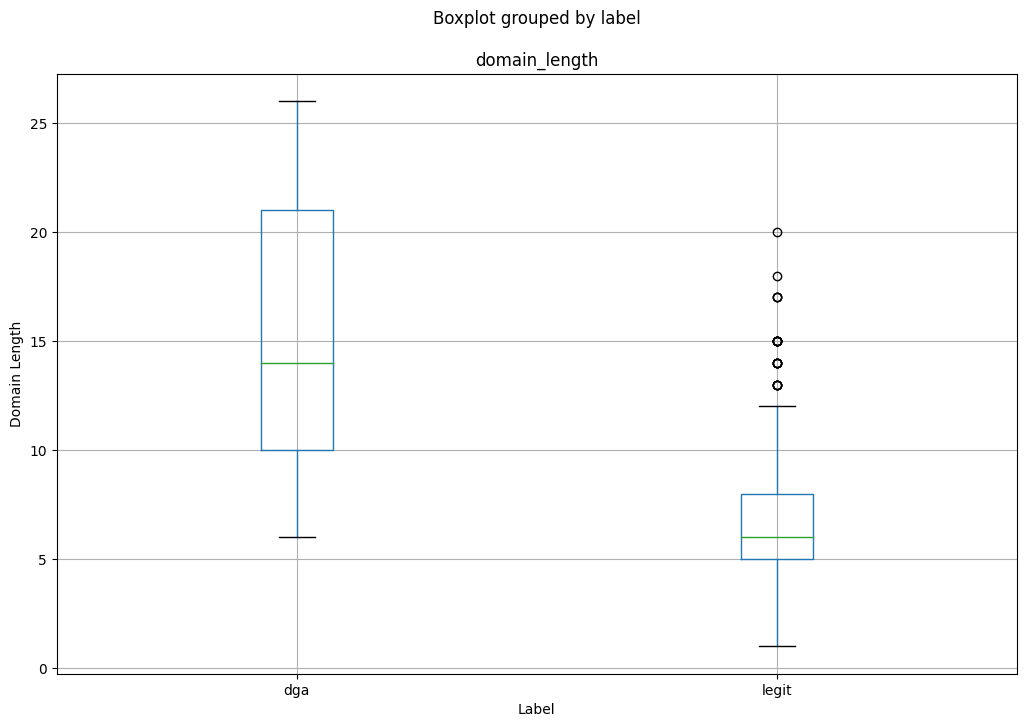

In [6]:
# Plot the distribution of domain length for both legit and dga domains by label
df_legit['label'] = 'legit'
df_dga['label'] = 'dga'
df = feature_extraction(pd.concat([df_legit, df_dga], ignore_index=True))

fig, ax = plt.subplots(figsize=(12, 8))
df.boxplot(column=['domain_length'], by=['label'], ax=ax)
ax.set_xlabel('Label')
ax.set_ylabel('Domain Length')
plt.show()

We can see that the domain length for the DGA generated domains is much larger (on average) than the legit domains with a few exceptions considering the outliers of the legit domains. This depends on the algorithm that is used to generate the malicious domains. 

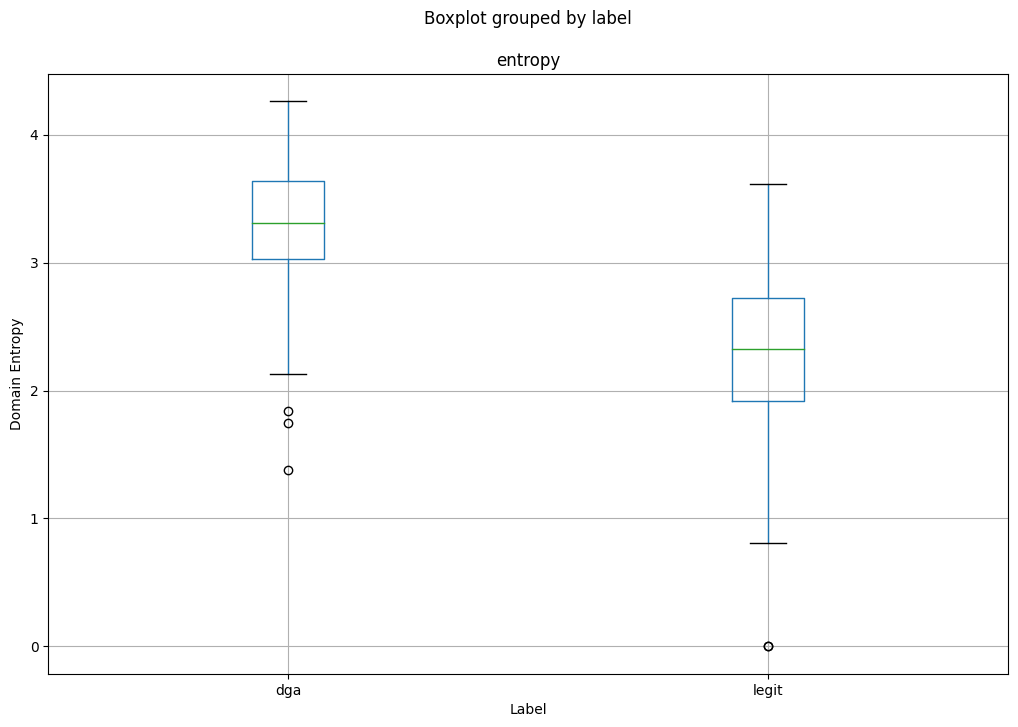

In [7]:
# Plot the distribution of domain length for both legit and dga domains by label
df_legit['label'] = 'legit'
df_dga['label'] = 'dga'
df = feature_extraction(pd.concat([df_legit, df_dga], ignore_index=True))

fig, ax = plt.subplots(figsize=(12, 8))
df.boxplot(column=['entropy'], by=['label'], ax=ax)
ax.set_xlabel('Label')
ax.set_ylabel('Domain Entropy')
plt.show()

We can see that the average entropy is larger for the dga generated domains as is has more randomly generated letters on average compared to the legit domains.  

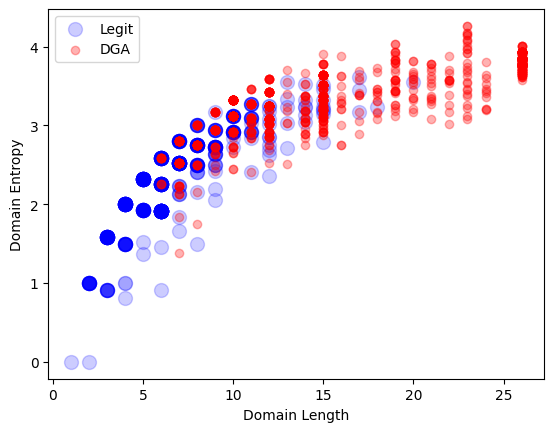

In [8]:
# Scatter 
plt.scatter(df_legit['domain_length'], df_legit['entropy'], s=100, color='blue', label='Legit', alpha=0.2)
plt.scatter(df_dga['domain_length'], df_dga['entropy'], color='red', label='DGA', alpha=0.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Domain Entropy')
plt.show()

In [9]:
print(df_legit.nlargest(10, 'entropy').loc[:, ['domain', 'entropy']])

                       domain   entropy
166     loading-delivery2.com  3.616875
57          stackoverflow.com  3.546594
72   adnetworkperformance.com  3.546439
489        youradexchange.com  3.521641
340       ero-advertising.com  3.506891
279       liveadexchanger.com  3.456565
444     thefreedictionary.com  3.454822
147         bankofamerica.com  3.334679
210        steamcommunity.com  3.324863
134       microsoftonline.com  3.323231


In [10]:
# Check the cross val scores
clf = RandomForestClassifier(n_estimators=20, max_depth=5)
y = np.array(df['label'].tolist())
cross_val_score(clf, df.drop(['domain', 'label'], axis=1), y, cv=5, n_jobs=2)

array([0.93666667, 0.79      , 0.89966555, 0.88628763, 0.72575251])

The cross validation scores are not bad, but they could be improved by adding N-grams to our dataset. Firstly, we will need to split our dataset. 

### Splitting datasets
The dataset is already labeled and it is split into a test set and a training set. The indices have been reset so that the missclassified examples could be viewed after evaluation. 

In [11]:
X = df.drop(['label'], axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Resetting the indices to check for missclasssifications later
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Print the shapes of the training and testing sets
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1197, 6)
y_train shape:  (1197,)
X_test shape:  (300, 6)
y_test shape:  (300,)


### Generating and adding N-grams

In [12]:
# Adding n-gram features
vectorizer = CountVectorizer(ngram_range=(2, 5), analyzer='char')

X_train_vec = vectorizer.fit_transform(X_train['domain'])
X_train_counts = np.log(X_train_vec.sum(axis=1))
X_train['log_counts'] = X_train_counts

X_test_vec = vectorizer.transform(X_test['domain'])
X_test_counts = np.log(X_test_vec.sum(axis=1))
X_test['log_counts'] = X_test_counts

### Plotting the N-gram log counts

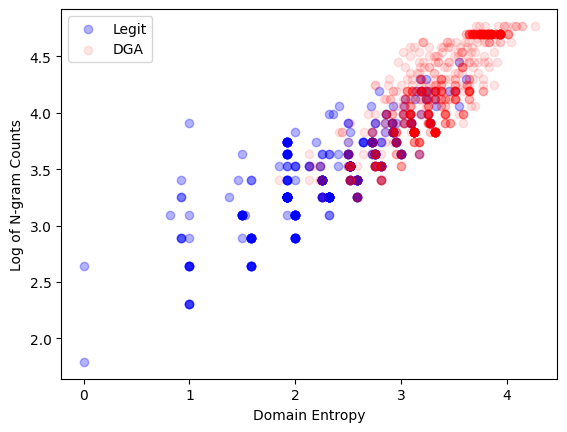

In [13]:
train_df = pd.concat([X_train, y_train], axis=1)

plt.scatter(train_df[train_df['label'] == 'legit']['entropy'], train_df[train_df['label'] == 'legit']['log_counts'], color='blue', label='Legit', alpha=0.3)
plt.scatter(train_df[train_df['label'] == 'dga']['entropy'], train_df[train_df['label'] == 'dga']['log_counts'], color='red', label='DGA', alpha=0.1)
plt.legend()
plt.xlabel('Domain Entropy')
plt.ylabel('Log of N-gram Counts')
plt.show()

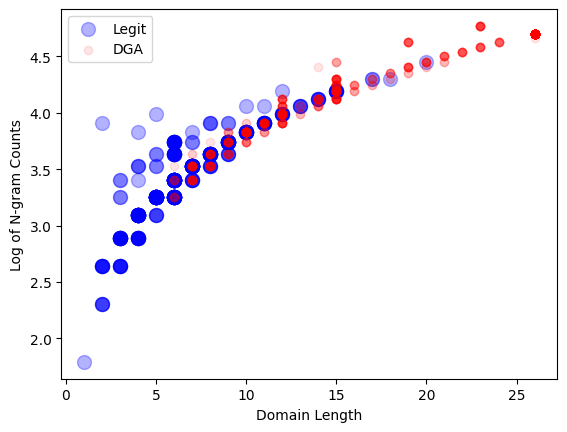

In [14]:
plt.scatter(train_df[train_df['label'] == 'legit']['domain_length'], train_df[train_df['label'] == 'legit']['log_counts'], s = 100, color='blue', label='Legit', alpha=0.3)
plt.scatter(train_df[train_df['label'] == 'dga']['domain_length'], train_df[train_df['label'] == 'dga']['log_counts'], color='red', label='DGA', alpha=0.1)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Log of N-gram Counts')
plt.show()

We can see from the plots that when the logs counts are compared to the domain entropy, the two classes are separate from each other while that comparisson when we compare the domain length and the log count is not as apparent when the domain lenght is between 10 to 15 characters. 

In [15]:
# Check the cross val scores
clf = RandomForestClassifier(n_estimators=20)
cross_val_score(clf, X_train.drop(['domain'], axis=1), y_train, cv=5, n_jobs=2)

array([0.84583333, 0.875     , 0.87447699, 0.87029289, 0.86192469])

### Grid Search

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [5, 7, 10, 12, 15, 17, 20],
    'min_samples_split': [2, 5, 7, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10]
}

rf = RandomForestClassifier()

# n_jobs=-1 means that the computation will be dispatched on all the available CPU cores to parallelize the search
# Create a GridSearchCV object with the specified hyperparameter grid and model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train.drop(['domain'], axis=1), y_train)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

with open('best_params.txt', 'w') as f:
    f.write(json.dumps(grid_search.best_params_))

with open('best_score.txt', 'w') as f:
    f.write(json.dumps(grid_search.best_score_))

Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 600}
Best score:  0.8830683403068342


In [30]:
# Create a new random forest classifier with the best hyperparameters
rf_best = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                  max_depth=grid_search.best_params_['max_depth'],
                                  min_samples_split=grid_search.best_params_['min_samples_split'],
                                  min_samples_leaf=grid_search.best_params_['min_samples_leaf'])

In [31]:
# Fit the new random forest classifier to the entire training dataset
rf_best.fit(X_train.drop(['domain'], axis=1), y_train, sample_weight=None)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=600)

In [32]:
# Evaluate the performance of the random forest classifier on the testing data
accuracy = rf_best.score(X_test.drop(['domain'], axis=1), y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.8666666666666667


### Save the model locally

In [33]:
pickle.dump(rf_best, open('randomforest.pkl', 'wb'))

In [34]:
y_test.value_counts()

label
dga      205
legit     95
Name: count, dtype: int64

Confusion matrix:
[[192  13]
 [ 27  68]]


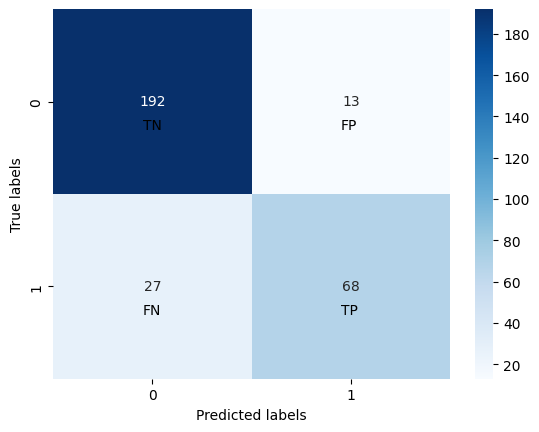

In [35]:
# Make predictions on the test set
y_pred = rf_best.predict(X_test.drop(['domain'], axis=1))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{cm}")

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":10})

# Add true positives, true negatives, false positives, and false negatives to the heatmap
plt.text(0.45, 0.65, f"TN", fontsize=10)
plt.text(0.45, 1.65, f"FN", fontsize=10)
plt.text(1.45, 0.65, f"FP", fontsize=10)
plt.text(1.45, 1.65, f"TP", fontsize=10)

# Set the axis labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Show the plot
plt.show()

### Calculating the evaluation metrics

In [36]:
# Calculate the F1 score for DGA class
f1 = f1_score(y_test, y_pred, pos_label='dga')
print(f"\nF1 score DGA: {f1}")
f1 = f1_score(y_test, y_pred, pos_label='legit')
print(f"\nF1 score Legit: {f1}\n")

# Generate the classification report
cr = classification_report(y_test, y_pred)
# Print the classification report
print(cr)


F1 score DGA: 0.9056603773584906

F1 score Legit: 0.7727272727272727

              precision    recall  f1-score   support

         dga       0.88      0.94      0.91       205
       legit       0.84      0.72      0.77        95

    accuracy                           0.87       300
   macro avg       0.86      0.83      0.84       300
weighted avg       0.86      0.87      0.86       300



We can see that the scores for the dga class are much better compared to the legit class as the model has a lower number of predicted false positives. 

In [37]:
# Getting the false positives and negatives

# Compare the predicted labels with the true labels
misclassified = X_test[y_pred != y_test]

# Print the misclassified examples
print(f"Number of misclassified examples: {len(misclassified)}")

Number of misclassified examples: 40


### FP and FN analysis

In [38]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

misclassified_indices = np.unique(misclassified.index.values)

misclassified_examples = X_test.iloc[misclassified_indices].copy()

misclassified_pred = y_pred[misclassified_indices]
misclassified_label = y_test[misclassified_indices]

misclassified_examples['label'] = misclassified_label
misclassified_examples['pred'] = misclassified_pred

misclassified_examples

,domain,domain_length,num_digits,num_consonants,num_vowels,entropy,log_counts,label,pred
0,livejasmin.com,10,0,8,5,3.121928,3.433987,legit,dga
5,snapdeal.com,8,0,7,4,2.750000,3.178054,legit,dga
6,infusionsoft.com,12,0,9,6,2.751629,3.663562,legit,dga
7,outbrain.com,8,0,6,5,3.000000,3.178054,legit,dga
9,youradexchange.com,14,0,10,7,3.521641,4.007333,legit,dga
12,deviantart.com,10,0,8,5,2.921928,3.367296,legit,dga
15,lfehajeex.com,9,0,7,5,2.641604,3.178054,dga,legit
20,netflix.com,7,0,7,3,2.807355,3.091042,legit,dga
22,olornomle.com,9,0,7,5,2.419382,3.555348,dga,legit
30,retailmenot.com,11,0,8,6,3.095795,3.433987,legit,dga


# Conclusion

Multiple models where considered for this solution, but the Random Forest classifier what used for its simplicity in use and the inherent properties of the malicious domains, such as a higher entropy, larger domain lenght, fast training and inference time (compared to deeper models). 

The addition of the following features:
- num_digits - The number of digits in the domain name
- num_consonants - The number of consonant in the domain name
- num_vowels - The number of vowels in the domain name

have been added as I have found out that the addition of these features has lowered the number of false positives to a minimum considering the provided dataset size (compared to using simply domain_lenght, entropy and log_counts).

The biggest hit on the accuracy of the model comes from the number of false negatives, this could surely be improved with further feature engineering and a larger dataset. I believe the biggest problem with the false negatives comes from their bigger domain length and larger entropy values. 

Further improvements could be made as was mentioned, by obtaining a dataset of valid domains and generating the malicious domains from this repo:
https://github.com/baderj/domain_generation_algorithms

Furthermore, an LSTM could be used for this case as well, but that would require a large dataset as it is a deep learning (NLP) model and more training time. 